# Utilisation du modèle SARIMA X pour prédire la consommation Electrique

- Granularité : 3 heures
- Valeur Exogène : **Oui**, les températures des 6 derniers ticks.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import utils

FILEPATH = 'clean_data//ener_conso_full.csv'
FILEPATH2 = 'clean_data/clean_data_meteo_3h.csv'

## Chargement des fichiers et preprocessing

In [8]:
conso = pd.read_csv(FILEPATH, parse_dates=[0], index_col=0, squeeze=True)
meteo = pd.read_csv(FILEPATH2)

In [9]:
conso = conso.resample('3H').sum()
conso.index

DatetimeIndex(['2012-12-31 21:00:00+00:00', '2013-01-01 00:00:00+00:00',
               '2013-01-01 03:00:00+00:00', '2013-01-01 06:00:00+00:00',
               '2013-01-01 09:00:00+00:00', '2013-01-01 12:00:00+00:00',
               '2013-01-01 15:00:00+00:00', '2013-01-01 18:00:00+00:00',
               '2013-01-01 21:00:00+00:00', '2013-01-02 00:00:00+00:00',
               ...
               '2019-12-30 18:00:00+00:00', '2019-12-30 21:00:00+00:00',
               '2019-12-31 00:00:00+00:00', '2019-12-31 03:00:00+00:00',
               '2019-12-31 06:00:00+00:00', '2019-12-31 09:00:00+00:00',
               '2019-12-31 12:00:00+00:00', '2019-12-31 15:00:00+00:00',
               '2019-12-31 18:00:00+00:00', '2019-12-31 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date_heure', length=20449, freq='3H')

In [10]:
to_drop = ['regioncode', 'rafales_sur_une_periode',
           'variation_de_pression_en_3_heures',
           'precipitations_dans_les_3_dernieres_heures', 'pression_station',
           'pression_au_niveau_mer', 'direction_du_vent_moyen',
           'vitesse_du_vent_moyen', 'humidite', 'point_de_rosee',
           'latitude', 'longitude', 'altitude',]

meteo = meteo.drop(to_drop, axis=1)
meteo['date'] = pd.to_datetime(meteo['date'])
meteo = meteo.set_index('date')
meteo = meteo['2012-12-31 21:00:00+00:00':'2019-12-31 21:00:00+00:00']
conso = conso['2012-12-31 21:00:00+00:00':'2019-12-31 21:00:00+00:00']

temperature_c    0
dtype: int64

In [5]:
conso_meteo=pd.merge(conso, meteo, right_index = True,
               left_index = True)

In [6]:
name = ['t-1', 't-2', 't-3', 't-4', 't-5']

for nom, i in zip(name, range(1,6)):
    conso_meteo[nom] = utils.shift(conso_meteo['temperature_c'], i)

conso_meteo = conso_meteo.dropna()

In [7]:
conso_meteo.head(5)

,consommation_mw,temperature_c,t-1,t-2,t-3,t-4,t-5
2013-01-01 12:00:00+00:00,324576.0,8.8875,7.5425,7.2000,7.2775,7.3275,7.5200
2013-01-01 15:00:00+00:00,329949.0,8.4350,8.8875,7.5425,7.2000,7.2775,7.3275
2013-01-01 18:00:00+00:00,363960.0,6.4100,8.4350,8.8875,7.5425,7.2000,7.2775
2013-01-01 21:00:00+00:00,356617.0,5.4425,6.4100,8.4350,8.8875,7.5425,7.2000
2013-01-02 00:00:00+00:00,329514.0,4.7650,5.4425,6.4100,8.4350,8.8875,7.5425


Pour travailler avec les granularité de 3 heures : nous prenons les 30 derniers jours.

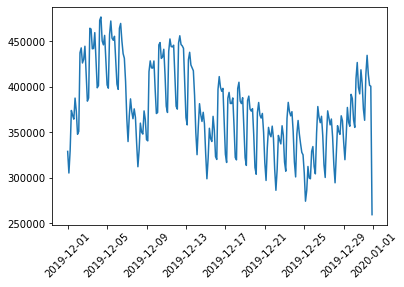

In [8]:
conso_meteo = conso_meteo['2019-12-01' : '2019-12-31']
target = conso_meteo['consommation_mw']
exo = conso_meteo.drop('consommation_mw', axis=1)

plt.plot(target)
plt.xticks(rotation=45)
plt.show()

Notre amplititude semble **constante**, nous pouvons supposer que nous sommes déjà dans **un modèle additif**.

**Décomposons** la série pour y voir plus claire sur la *tendance, la saisonnalité et le résidu*:

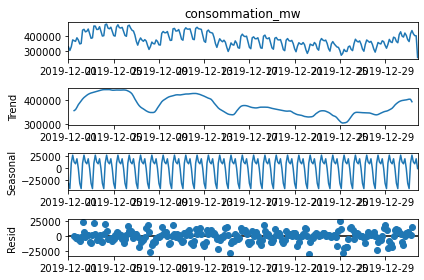

In [9]:
res = seasonal_decompose(target, period = 8, model='additive')
res.plot()
plt.show()

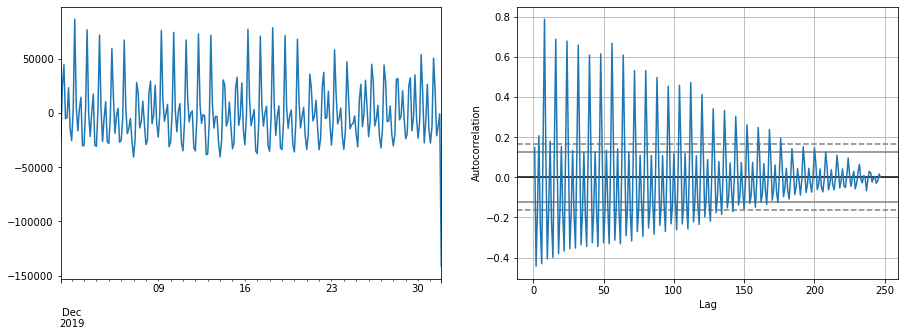

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

target_1 = target.diff().dropna() # Différenciation ordre 1

target_1.plot(ax = ax1) #Série temporelle différenciée

pd.plotting.autocorrelation_plot(target_1, ax = ax2); #Autocorrélogramme de la série différenciée

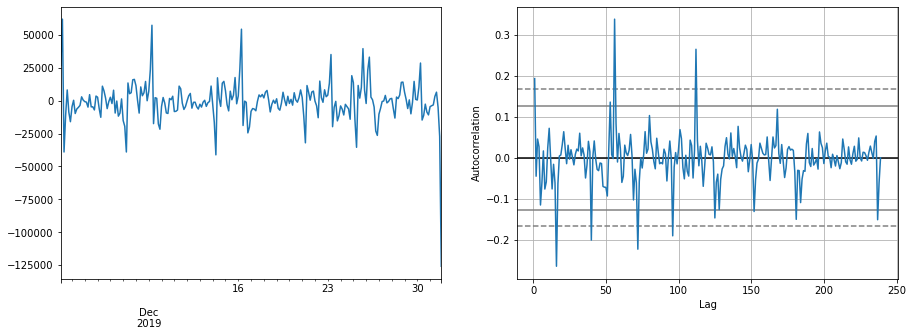

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

target_2 = target_1.diff(8).dropna() # Différenciation ordre 8

target_2.plot(ax = ax1) #Série temporelle différenciée

pd.plotting.autocorrelation_plot(target_2, ax = ax2); #Autocorrélogramme de la série différenciée

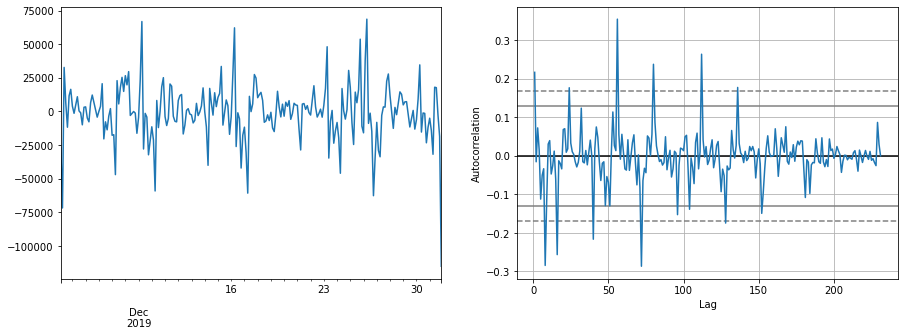

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

target_3 = target_2.diff(8).dropna() # Différenciation ordre 8

target_3.plot(ax = ax1) #Série temporelle différenciée

pd.plotting.autocorrelation_plot(target_3, ax = ax2); #Autocorrélogramme de la série différenciée

**Le modèle additif se confirme et la saisonnalité semble présenter une période de 48 ticks.**

In [13]:
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(target_2)
p_value  

1.8322839391679622e-05

**p-valeur inférieur à 1% on peut considérer la série comme stationnaire !**

nous identifions une saisonnalité de période 8 ( k=8 ). De plus nous avons fait une différenciation simple ( d=1 ) et une différenciation saisonnière ( D=1 ) pour stationnariser notre série temporelle.

Ainsi notre modèle sera de la forme SARIMA(p,1,q)(P,1,Q)8. Il convient alors de choisir les bons ordres p , q , P et Q pour nos processus ARMA.

## Boucle permettant de trouver les meilleurs paramètres grâce à l'AIC

#### Sans oublier de rajouter les valeurs exogènes de température*

In [14]:
import warnings
warnings.filterwarnings('ignore')

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]

params_results = {}
print("Calcul en cours...")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(target,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog = exo,
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}8'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue


best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])

Calcul en cours...
ARIMA(1, 1, 1)x(1, 1, 1, 8)8 AIC : 5267.0


# Calcul avec les paramètres ayant l'AIC le plus bas :

In [15]:
model = sm.tsa.SARIMAX(target,exog =exo, order=(1,1,1), seasonal_order=(1,1,1,8))

sarima=model.fit()

print(sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                   consommation_mw   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 8)   Log Likelihood               -2622.343
Date:                           Fri, 19 Nov 2021   AIC                           5266.686
Time:                                   11:39:31   BIC                           5304.927
Sample:                               12-01-2019   HQIC                          5282.096
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temperature_c -1623.7877   2140.373     -0.759      0.448   -5818.841    2571.266
t-1           -4609.8260   2884.52

**Il semblerait que la température n-1 et n-2 sont les paramètres ayant le plus de significativité au sein de nos variables exogènes.**

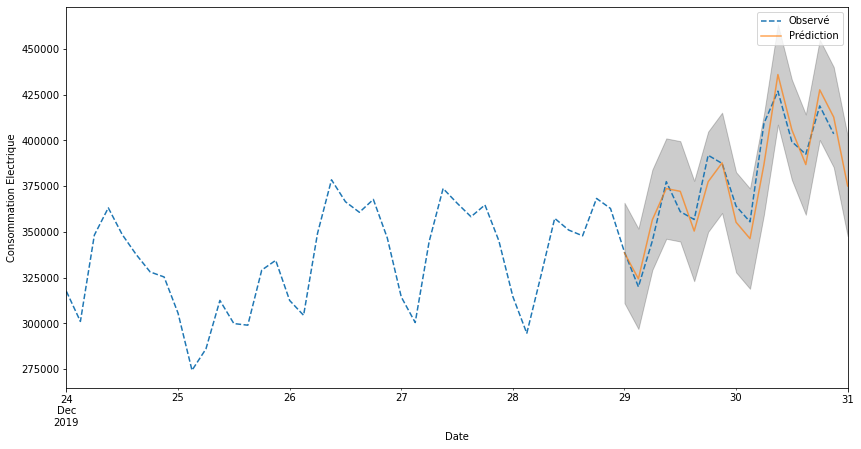

In [27]:
pred = sarima.get_prediction(start=pd.to_datetime('2019-12-29', utc=True), end=pd.to_datetime('2019-12-31', utc=True), dynamic=False)
pred_ci = pred.conf_int()

ax = target['2019-12-24':'2019-12-30'].plot(label='Observé', style='--')
pred.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation Electrique')
plt.legend()
plt.show()

On observe que notre modèle réagit très bien pour prédire la consommation. 

NB : La grande descente est certainement dû au manque de données de nos DataSet concernant l'année 2020...

# Avec X = meteo

In [5]:
FILEPATH = 'clean_data//ener_conso_full.csv'
FILEPATH2 = 'clean_data/clean_data_meteo_3h.csv'

conso = pd.read_csv(FILEPATH, parse_dates=[0], index_col=0, squeeze=True)
meteo = pd.read_csv(FILEPATH2)
conso = conso.resample('3H').sum()
to_drop = ['regioncode','latitude', 'longitude', 'altitude',]

meteo = meteo.drop(to_drop, axis=1)
meteo['date'] = pd.to_datetime(meteo['date'])
meteo = meteo.set_index('date')
meteo = meteo['2019-12-01' : '2019-12-31']
conso = conso['2019-12-01' : '2019-12-31']

In [6]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(conso,
                                            order= param,
                                            seasonal_order=param_seasonal,
                                            exog = meteo
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}12'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 AIC : 5466.0
Calcul terminé.
